In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.instruments.instrument_subgroups import (
    sort_elemnts_by_another,
    SubgroupFinder,
)
from cgtasknet.tasks.reduce import ReduceTaskCognitive
from norse.torch import LIFAdExState


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self,
        model: torch.nn.Module,
        tasks: Iterable[ReduceTaskCognitive],
        type_tasks=list,
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = None
        self._type_tasks = type_tasks

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for k in range(len(self._tasks)):
            current_task = self._tasks[k]
            t0 = time.perf_counter()
            self._subgroups_finder.append(SubgroupFinder(dt))
            trigger = self._type_tasks[k]
            for i in range(number_of_trials):
                status = False
                while not status:
                    inputs, t_outputs, s, out = self._run_trial(current_task, trigger)

                    status = self._subgroups_finder[-1].compute_average_freq(
                        [s.to(torch.device("cpu"))],
                        [inputs[:, 0, 0].to(torch.device("cpu"))],
                        [out.to(torch.device("cpu"))],
                        [t_outputs.to(torch.device("cpu"))],
                    )
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )
            # print(t_outputs[-1, 0, 1])

    def _run_trial(self, task: ReduceTaskCognitive, trigger):
        inputs, t_outputs = task.dataset()

        if trigger != 0:
            while t_outputs[-1, 0, 1] != 2 - trigger:
                inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        init_state = LIFAdExState(
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 1,
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 0.0,
        )
        out, _, s = self._model(inputs, init_state)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):
        fixation = []
        answer = []
        for subgoup_finder in self._subgroups_finder:
            t_fixation, t_answer = subgoup_finder.get_average_freq()
            fixation.append(t_fixation)
            answer.append(t_answer)
        return fixation, answer

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [30]:
go_task_list_values = np.linspace(0, 1, 8)
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.25,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}
tasks_sequence = []
sorted_tasks = sorted(tasks)
i = 0
while i < len(tasks):
    tasks_sequence.append(
        MultyReduceTasks(
            tasks=task_dict,
            batch_size=batch_size,
            delay_between=0,
            enable_fixation_delay=True,
            task_number=i,
        )
    )
    if "DM" in sorted_tasks[i] or "Romo" in sorted_tasks[i]:
        tasks_sequence.append(
            MultyReduceTasks(
                tasks=task_dict,
                batch_size=batch_size,
                delay_between=0,
                enable_fixation_delay=True,
                task_number=i,
            )
        )
    i += 1

In [31]:
len(tasks_sequence)

18

In [32]:
tasks_couples = [
    "RomoTask1: 1",
    "RomoTask1: 2",
    "RomoTask2: 1",
    "RomoTask2: 2",
    "DMTask1: 1",
    "DMTask1: 2",
    "DMTask2: 1",
    "DMTask2: 2",
    "CtxDMTask1: 1",
    "CtxDMTask1: 2",
    "CtxDMTask2: 1",
    "CtxDMTask2: 2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
print(sorted(tasks_couples), len(tasks_couples))

['CtxDMTask1: 1', 'CtxDMTask1: 2', 'CtxDMTask2: 1', 'CtxDMTask2: 2', 'DMTask1: 1', 'DMTask1: 2', 'DMTask2: 1', 'DMTask2: 2', 'GoDlTask1', 'GoDlTask2', 'GoRtTask1', 'GoRtTask2', 'GoTask1', 'GoTask2', 'RomoTask1: 1', 'RomoTask1: 2', 'RomoTask2: 1', 'RomoTask2: 2'] 18


In [33]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256
tau_a = "1/2"
neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=float(eval(tau_a)),
    alpha=100,
    method="super",
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=50,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        rf"A:\src\multy_task\models\low_freq\bound_and_square_after\weights\weights_100_N_256_1999_",
        # r"A:\src\multy_task\notebooks\train\reduce\lif_adex\romo_dm_ct_go_gort_godl\long_intervals_list_go_task_improve_correct_functions_two_trials\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450",
        map_location=device,
    )
)
# tau_a = neuron_parameters.tau_ada_inv

<All keys matched successfully>

In [34]:
from sklearn.cluster import KMeans

type_tasks = []
tasks_couples.sort()
print(tasks_couples)
for i in range(len(tasks_couples)):
    if ": 1" in tasks_couples[i]:
        type_tasks.append(1)
    elif ": 2" in tasks_couples[i]:
        type_tasks.append(2)
    else:
        type_tasks.append(0)

subgroups = EveryTaskSubgroups(model, tasks_sequence, type_tasks)

subgroups.device = device
fixations, answers = [], []
for i in range(100):
    print(f"{i=}")
    subgroups.run(1)
    fix, ans = subgroups.get_frequencies()
    fixations.append(
        [el.detach().cpu().numpy() if el is not None else None for el in fix]
    )
    answers.append([el.detach().cpu().numpy() for el in ans])

['CtxDMTask1: 1', 'CtxDMTask1: 2', 'CtxDMTask2: 1', 'CtxDMTask2: 2', 'DMTask1: 1', 'DMTask1: 2', 'DMTask2: 1', 'DMTask2: 2', 'GoDlTask1', 'GoDlTask2', 'GoRtTask1', 'GoRtTask2', 'GoTask1', 'GoTask2', 'RomoTask1: 1', 'RomoTask1: 2', 'RomoTask2: 1', 'RomoTask2: 2']
i=0
******************** Start
Complete task: 0, time: 0.2392211999999745s
Complete task: 0, time: 0.4185629000000972s
Complete task: 1, time: 0.19221670000001723s
Complete task: 1, time: 0.1695878000000448s
Complete task: 2, time: 0.2605083000000832s
Complete task: 2, time: 0.42984480000018266s
Complete task: 3, time: 0.29551409999999123s
Complete task: 3, time: 0.31010139999989406s
Complete task: 4, time: 0.5738506000000143s
Complete task: 5, time: 1.3055490000001555s
Complete task: 6, time: 1.422378799999933s
Complete task: 7, time: 1.5487066999999115s
Complete task: 8, time: 0.5138970000000427s
Complete task: 9, time: 0.38037469999994755s
Complete task: 10, time: 0.7481047999999646s
Complete task: 10, time: 0.59557140000015

In [8]:
fixation_both_cat = []
answer_both_cat = []
for i in range(0, len(fixations), 2):
    fixation_both_cat.append((fixations[i] + fixations[i + 1]) / 2)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [10]:
fixations[0]

[array([0.00000000e+00, 1.11482716e+00, 0.00000000e+00, 1.11482716e+00,
        0.00000000e+00, 1.11482716e+00, 0.00000000e+00, 5.57413578e-01,
        5.57413578e-01, 5.57413578e-01, 5.57413578e-01, 5.57413578e-01,
        5.57413578e-01, 0.00000000e+00, 5.57413578e-01, 1.11482716e+00,
        5.57413578e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.57413578e-01, 5.57413578e-01, 0.00000000e+00, 5.57413578e-01,
        0.00000000e+00, 5.57413578e-01, 0.00000000e+00, 0.00000000e+00,
        5.57413578e-01, 5.57413578e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.36120377e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.57413578e-01,
        5.57413578e-01, 0.00000000e+00, 1.00334444e+01, 1.11482716e+00,
        5.57413578e-01, 1.17056847e+01, 0.00000000e+00, 0.00000000e+00,
        2.84280930e+01, 0.00000000e+00, 8.36120319e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.67892952e+01, 0.000000

In [5]:
answers_np = np.array(answers).T
answers_np = answers_np.reshape(
    answers_np.shape[-1] * answers_np.shape[-2], answers_np.shape[0]
).T
# indexes = np.where(answers_np.mean(axis=1) > 25)[0]
answers_np = np.concatenate(answers).T + 1
# answers_np = answers_np[indexes, :]
answers_np = (answers_np.T / np.sum(answers_np, axis=1)).T
print(answers_np.shape)

NameError: name 'np' is not defined

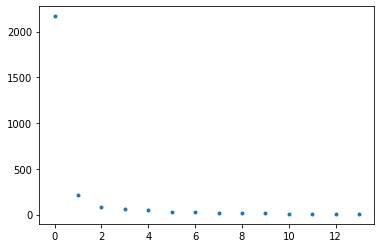

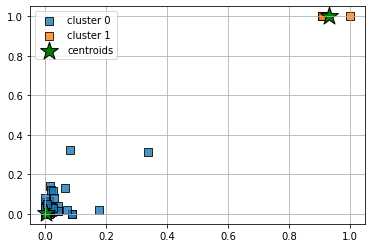

In [8]:
X = np.concatenate(fixations, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse_fixation = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse_fixation.append(kmeans.inertia_)
plt.plot(sse_fixation, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

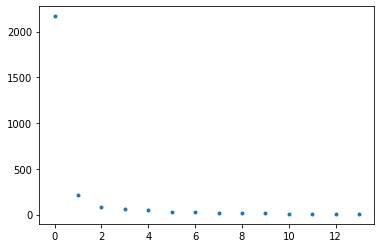

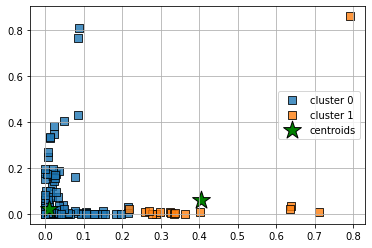

In [9]:
X = np.concatenate(answers, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse_answer = []

for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse_answer.append(kmeans.inertia_)
plt.plot(sse_fixation, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

NameError: name 'sse_fixation' is not defined

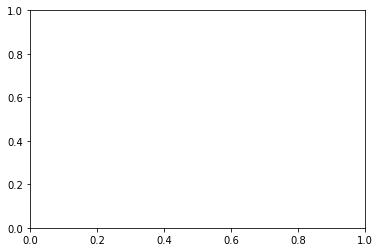

In [8]:
plt.rcParams["font.size"] = 10
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

ax1.plot(
    range(1, len(sse_fixation) + 1),
    sse_fixation,
    ".",
    linestyle="--",
    label="Fixation stage",
)
ax1.set_ylabel("$J(C_k)$")
ax1.plot(
    range(1, len(sse_fixation) + 1),
    sse_answer,
    ".",
    linestyle="--",
    label="Answer stage",
)
ax1.set_xlim([1, len(sse_fixation)])
ax1.set_xticks(range(1, len(sse_fixation) + 1))
ax1.set_ylim([min(sse_fixation), max(sse_fixation)])

ax1.minorticks_on()
ax1.grid(True)
ax1.grid(which="minor", linestyle="--", alpha=0.8)
ax1.set_xlabel("$k$")
plt.legend()
plt.savefig("J_vs_k.eps")
plt.show()
plt.close()

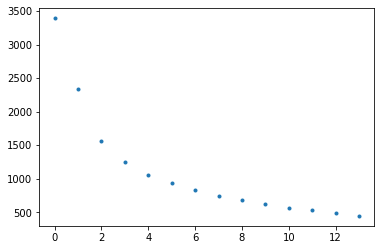

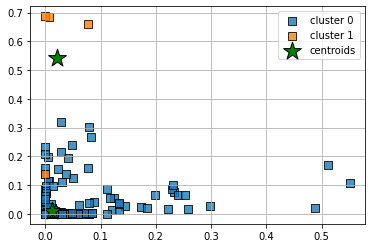

In [16]:
X = np.concatenate(answers, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

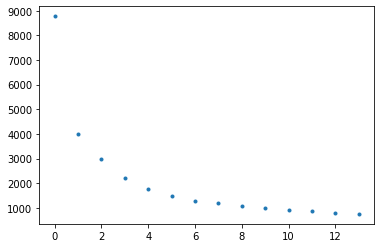

UsageError: Line magic function `%` not found.


In [17]:
X = np.concatenate(answers + fixations, axis=0).T / 2

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 2
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
% matplotlib inline
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
np_variance = np.zeros((np_answers.shape[1], np_answers.shape[2]))
for i in range(np_answers.shape[-1]):
    np_variance[:, i] = np.sum(np_answers[:, :, i], axis=0) / 100

In [ ]:
np_variance.shape

In [ ]:
plt.imshow(np_variance / np_variance.max(), aspect="auto", cmap="jet", origin="lower")
plt.colorbar()

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(
    X
)  # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(
    distance_mat, "single"
)  # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=000)
plt.show()
plt.close()

In [ ]:
X = np.concatenate(answers, axis=0).T
X = X[np.where(X.sum(axis=1) > 950)[0], :]
X.shape

In [ ]:
zero_neurons = set(
    (
        3,
        5,
        9,
        11,
        14,
        17,
        18,
        21,
        22,
        23,
        29,
        30,
        32,
        35,
        39,
        41,
        46,
        48,
        56,
        58,
        60,
        62,
        63,
        71,
        75,
        78,
        79,
        81,
        86,
        87,
        90,
        94,
        95,
        98,
        99,
        100,
        102,
        106,
        108,
        110,
        111,
        115,
        116,
        120,
        125,
        127,
        134,
        135,
        136,
        142,
        145,
        147,
        151,
        154,
        157,
        163,
        165,
        168,
        176,
        178,
        182,
        184,
        190,
        192,
        193,
        194,
        197,
        204,
        207,
        209,
        211,
        214,
        216,
        224,
        233,
        236,
        237,
        240,
        251,
        254,
        255,
        263,
        264,
        271,
        272,
        275,
        276,
        279,
        288,
        289,
        291,
        294,
        297,
        298,
        299,
        301,
        303,
        305,
        307,
        313,
        315,
        317,
        322,
        323,
        325,
        326,
        327,
        329,
        331,
        334,
        335,
        338,
        340,
        342,
        345,
        348,
        349,
        360,
        366,
        372,
        382,
        383,
        385,
        390,
        391,
        392,
        393,
        394,
    )
)
non_zeros_neurons = set([*range(hidden_size)]) - zero_neurons
non_zeros_neurons = sorted(list(non_zeros_neurons))
X = np.concatenate(answers, axis=0).T[non_zeros_neurons, ...]

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
sse = []
for k in range(1, 15):
    kmeans = KMeans(k, algorithm="full", n_init=20, random_state=0)
    kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
plt.plot(sse, ".")
plt.show()
plt.close()
n_clusters = 3
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.ylabel("$J(C)$")
plt.grid()
plt.show()

In [ ]:
plt.plot(sse, ".")
plt.ylabel("$J(C)$")
plt.xlabel("Number of clusters")
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(sse, ".")
plt.ylabel("$J(C)$")
plt.xlabel("Number of clusters")
plt.savefig("J_answer.eps")
plt.show()

(256, 1800)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


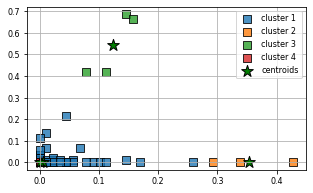

In [41]:
zero_neurons = set(
    (
        3,
        5,
        9,
        11,
        14,
        17,
        18,
        21,
        22,
        23,
        29,
        30,
        32,
        35,
        39,
        41,
        46,
        48,
        56,
        58,
        60,
        62,
        63,
        71,
        75,
        78,
        79,
        81,
        86,
        87,
        90,
        94,
        95,
        98,
        99,
        100,
        102,
        106,
        108,
        110,
        111,
        115,
        116,
        120,
        125,
        127,
        134,
        135,
        136,
        142,
        145,
        147,
        151,
        154,
        157,
        163,
        165,
        168,
        176,
        178,
        182,
        184,
        190,
        192,
        193,
        194,
        197,
        204,
        207,
        209,
        211,
        214,
        216,
        224,
        233,
        236,
        237,
        240,
        251,
        254,
        255,
        263,
        264,
        271,
        272,
        275,
        276,
        279,
        288,
        289,
        291,
        294,
        297,
        298,
        299,
        301,
        303,
        305,
        307,
        313,
        315,
        317,
        322,
        323,
        325,
        326,
        327,
        329,
        331,
        334,
        335,
        338,
        340,
        342,
        345,
        348,
        349,
        360,
        366,
        372,
        382,
        383,
        385,
        390,
        391,
        392,
        393,
        394,
    )
)
zero_neurons = set()
non_zeros_neurons = set([*range(hidden_size)]) - zero_neurons
non_zeros_neurons = sorted(list(non_zeros_neurons))
X = np.concatenate(answers, axis=0).T[non_zeros_neurons, ...]
# X = np.concatenate(answers, axis=0).T
print(X.shape)
# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 4
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
plt.figure(figsize=(5, 3))
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i + 1}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=150,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.savefig("NumberOfClusters.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


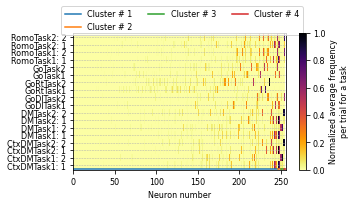

In [42]:
plt.rcParams["font.size"] = 8
answers_np = np.array(answers)
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)[:, non_zeros_neurons]
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
tv.shape

sort_indexes = [*range(tv.shape[-1])]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    if i == 1:
        clusters.extend(
            sort_elemnts_by_another(
                np.mean(tv[8:14, [*np.where(y_km == i)[0]]], axis=0),
                [*np.where(y_km == i)[0]],
            )
        )
    else:
        clusters.extend(
            sort_elemnts_by_another(
                np.mean(tv[:, [*np.where(y_km == i)[0]]], axis=0),
                [*np.where(y_km == i)[0]],
            )
        )
        # sort_elemnts_by_another(tv[9, [*np.where(y_km == i)[0]]], [*np.where(y_km == i)[0]]))
clusters = clusters[::1]
for task in range(len(tv)):
    for i in range(tv.shape[-1]):
        tv_sort[task, i] = tv[task, clusters[i]]

# plt.imshow(np.concatenate((tv_sort[:, 0: 50], tv_sort[:, 440:]), axis=1), aspect='auto', origin='lower', cmap='rainbow',
#           interpolation='nearest')
plt.figure(figsize=(5, 3))
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="inferno_r", interpolation="nearest"
)
cluster_sizes = []
for i in range(n_clusters):
    cluster_i = [*np.where(y_km == i)[0]]
    cluster_sizes.append(len(cluster_i))
# for el in (cluster_sizes[::1]):
#    plt.plot([el] * 2, [0, len(tasks)], c='black', alpha=.5)
plt.yticks(np.arange(0, len(tasks_couples)), sorted(tasks_couples), rotation=0)
plt.ylim(-0.6, len(tasks_couples) - 0.4)
# plt.xlim(0, 50)
plt.xlabel("Neuron number")
cb = plt.colorbar()
cb.ax.set_ylabel("Normalized average frequency\nper trial for a task")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", linewidth=0.5)
cluster_size = 0
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
for i in range(0, len(cluster_sizes)):
    plt.plot(
        [cluster_size, cluster_size + cluster_sizes[i]],
        [-0.5, -0.5],
        label=f"Cluster # {i + 1}",
        # c=colors[i]))
    )
    # plt.plot([cluster_size ] * 2, [-1, len(tasks_couples)], c='black', linestyle='--', linewidth=.5)
    cluster_size += cluster_sizes[i]

plt.xlim([0, tv.shape[-1]])
plt.legend(bbox_to_anchor=(0.1, 1.02, 1, 0.2), ncol=3)
# plt.xlim([500, 600])
plt.tight_layout()
plt.savefig("TaskClusters_answers.eps", format="eps")
plt.savefig("TaskClusters.png", dpi=1000)

plt.show()
plt.close()

(256, 1800)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


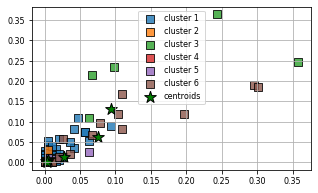

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


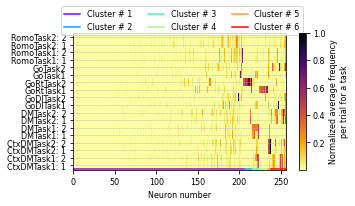

In [43]:
from matplotlib import cm

plt.rcParams["font.size"] = 8
zero_neurons = set(
    (
        4,
        5,
        6,
        10,
        11,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        25,
        26,
        27,
        28,
        31,
        32,
        33,
        34,
        36,
        37,
        38,
        39,
        40,
        41,
        43,
        44,
        48,
        49,
        50,
        51,
        52,
        53,
        54,
        55,
        56,
        57,
        59,
        62,
        63,
        65,
        66,
        68,
        70,
        71,
        72,
        73,
        74,
        75,
        76,
        78,
        79,
        80,
        81,
        83,
        84,
        85,
        86,
        87,
        88,
        90,
        91,
        92,
        93,
        94,
        96,
        97,
        98,
        99,
        100,
        101,
        102,
        103,
        104,
        105,
        106,
        107,
        109,
        110,
        113,
        114,
        115,
        116,
        117,
        118,
        119,
        120,
        121,
        122,
        123,
        124,
        125,
        126,
        127,
        128,
        129,
        131,
        133,
        134,
        135,
        136,
        137,
        138,
        139,
        142,
        143,
        145,
        146,
        147,
        149,
        150,
        153,
        155,
        157,
        158,
        159,
        160,
        161,
        162,
        163,
        164,
        165,
        166,
        167,
        168,
        169,
        170,
        171,
        173,
        176,
        177,
        178,
        179,
        180,
        181,
        182,
        183,
        184,
        185,
        186,
        187,
        189,
        190,
        191,
        192,
        193,
        195,
        197,
        198,
        199,
        200,
        201,
        202,
        203,
        204,
        205,
        206,
        208,
        209,
        210,
        211,
        212,
        216,
        218,
        219,
        220,
        221,
        222,
        223,
        224,
        226,
        227,
        229,
        233,
        234,
        235,
        236,
        237,
        238,
        239,
        241,
        242,
        243,
        244,
        245,
        246,
        247,
        248,
        249,
        250,
        251,
        252,
        253,
        257,
        258,
        259,
        260,
        262,
        263,
        266,
        267,
        269,
        271,
        272,
        274,
        276,
        277,
        278,
        279,
        280,
        281,
        283,
        284,
        286,
        287,
        291,
        292,
        293,
        295,
        296,
        297,
        299,
        300,
        301,
        302,
        304,
        306,
        307,
        309,
        310,
        311,
        313,
        314,
        315,
        316,
        317,
        318,
        319,
        320,
        321,
        322,
        323,
        324,
        325,
        327,
        328,
        329,
        330,
        331,
        332,
        334,
        335,
        336,
        337,
        339,
        341,
        342,
        343,
        346,
        348,
        349,
        350,
        352,
        353,
        355,
        357,
        358,
        360,
        362,
        363,
        366,
        367,
        368,
        370,
        371,
        372,
        373,
        374,
        375,
        376,
        378,
        379,
        381,
        382,
        383,
        384,
        385,
        386,
        387,
        389,
        391,
        392,
        393,
        395,
        396,
        397,
        398,
        399,
    )
)
zero_neurons = set()
non_zeros_neurons = set([*range(hidden_size)]) - zero_neurons
non_zeros_neurons = sorted(list(non_zeros_neurons))
X = np.concatenate(fixations, axis=0).T[non_zeros_neurons, ...]
# X = np.concatenate(answers, axis=0).T
print(X.shape)
# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 6
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
plt.figure(figsize=(5, 3))
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i + 1}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=150,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.savefig("NumberOfClusters.eps")
plt.show()
answers_np = np.array(fixations)
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)[:, non_zeros_neurons]
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
tv.shape

sort_indexes = [*range(tv.shape[-1])]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    # if i == 0:
    #    clusters.extend(
    #        sort_elemnts_by_another(np.mean(tv[8:14, [*np.where(y_km == i)[0]]], axis=0), [*np.where(y_km == i)[0]]))
    # else:
    clusters.extend(
        sort_elemnts_by_another(
            np.mean(tv[:, [*np.where(y_km == i)[0]]], axis=0), [*np.where(y_km == i)[0]]
        )
    )
    # sort_elemnts_by_another(tv[9, [*np.where(y_km == i)[0]]], [*np.where(y_km == i)[0]]))
clusters = clusters[::1]
for task in range(len(tv)):
    for i in range(tv.shape[-1]):
        tv_sort[task, i] = tv[task, clusters[i]]

# plt.imshow(np.concatenate((tv_sort[:, 0: 50], tv_sort[:, 440:]), axis=1), aspect='auto', origin='lower', cmap='rainbow',
#           interpolation='nearest')
plt.figure(figsize=(5, 3))
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="inferno_r", interpolation="nearest"
)
cluster_sizes = []
for i in range(n_clusters):
    cluster_i = [*np.where(y_km == i)[0]]
    cluster_sizes.append(len(cluster_i))
# for el in (cluster_sizes[::1]):
#    plt.plot([el] * 2, [0, len(tasks)], c='black', alpha=.5)
plt.yticks(np.arange(0, len(tasks_couples)), sorted(tasks_couples), rotation=0)
plt.ylim(-0.6, len(tasks_couples) - 0.4)
# plt.xlim(0, 50)
plt.xlabel("Neuron number")
cb = plt.colorbar()
cb.ax.set_ylabel("Normalized average frequency\nper trial for a task")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", linewidth=0.5)
cluster_size = 0
# colors = ["#EF3B3B", "#233DFB", "#49FF00"]
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
for i in range(0, len(cluster_sizes)):
    plt.plot(
        [cluster_size, cluster_size + cluster_sizes[i]],
        [-0.5, -0.5],
        label=f"Cluster # {i + 1}",
        c=colors[i],
    )
    cluster_size += cluster_sizes[i]
plt.xlim([0, tv.shape[-1] - 0.4])
plt.legend(bbox_to_anchor=(0.1, 1.02, 1, 0.2), ncol=3)
plt.tight_layout()
plt.savefig("TaskClusters_fixations.eps")
plt.savefig("TaskClusters.png", dpi=1000)
plt.show()
plt.close()

In [19]:
cluster_sizes = []
for i in range(n_clusters):
    cluster_i = [*np.where(y_km == i)[0]]
    cluster_sizes.append(len(cluster_i))
cluster_sizes

[11, 217, 11, 3, 14]

In [ ]:
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
# plt.xlim(0, 100)
plt.colorbar()
plt.show()
plt.close()

In [ ]:
clusters = X = np.concatenate(fixations, axis=0).T

# X = X[np.where(X.sum(axis=1) > 0)[0], :]
X = (X.T / X.max()).T
n_clusters = 4
km = KMeans(n_clusters, algorithm="full", n_init=20, random_state=0)
y_km = km.fit_predict(X)
for i in range(n_clusters):
    plt.scatter(
        X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        marker="s",
        edgecolor="black",
        label=f"cluster {i}",
        alpha=0.8,
    )
# plt.xlim([0, 0.00005])
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=350,
    marker="*",
    c="green",
    edgecolor="black",
    label="centroids",
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()
answers_np = np.array(answers)
tv = [answers_np[:, i, :].sum(axis=0) for i in range(answers_np.shape[1])]
tv = np.array(tv)
# tv = tv[np.where(tv.sum(axis=1) > 0)[0], :]
tv /= tv.max()
tv.shape
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

sort_indexes = [*range(hidden_size)]
sort_indexes = sort_elemnts_by_another(tv[1], sort_indexes)
tv_sort = np.zeros_like(tv)
clusters = []
for i in range(n_clusters):
    clusters.extend([*np.where(y_km == i)[0]])
clusters = clusters[::-1]
for task in range(len(tv)):
    for i in range(hidden_size):
        tv_sort[task, i] = tv[task, clusters[i]]
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
plt.xlim(0, 50)
plt.colorbar()
plt.show()
plt.close()
plt.imshow(
    tv_sort, aspect="auto", origin="lower", cmap="rainbow", interpolation="nearest"
)
plt.yticks(np.arange(0, len(tasks)), sorted(tasks), rotation=0)
# plt.xlim(0, 100)
plt.colorbar()
plt.show()
plt.close()

In [ ]:
fixations[9][2]